# Activity 4.2. Document Clustering
In this activity, we study the performance of KMeans algorithm on a document clustering problem. In the assessments, you will be  asked to expand this activity and develop an EM based document clustering algorithm using both soft and hard approches. 

(*The followings are partly barrowed from: http://michael.hahsler.net/SMU/CSE7337/install/tm.R*)

## Data
We use a subset of a publicly available dataset called 20 Newsgroups originally published in http://qwone.com/~jason/20Newsgroups/. This dataset contains more than 18K documents covering 20 different topics. For the simplicity and reducing the execution and evaluation times, we only use 1000 samples randomly selected from 4 categories. The filtered data is stored in `20ng-train-all-terms.txt` file.

In [1]:
## read the file (each line of the text file is one document)
text <- readLines('./20ng-train-all-terms.txt')

## randomly selet some samples
index <- sample(length(text), 400)
text <- text[index]

## the terms before '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
docs <- strsplit(text, '\t')
rm(text) # just free some memory!

# store the labels for evaluation
labels <-  unlist(lapply(docs, function(x) x[1]))

# store the unlabeled texts    
docs <- data.frame(unlist(lapply(docs, function(x) x[2])))
    

## Feature Extraction
Prior doing any clustering, we need to extract some meaningful features from the datasets. The features should be numerical, otherwise our Euclidean distance (non-similarity) measure will not work. To do so, we use a popular R package called `tm` to tailor the texts and calculate word counts (frequency of each word in each single document) as the features.

In [2]:
# load Text Mining library
library(tm)

# create a corpus
docs <- DataframeSource(docs)
docs <- Corpus(docs)

# Preprocessing:
docs <- tm_map(docs, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
docs <- tm_map(docs, removePunctuation) # remove pnctuation
docs <- tm_map(docs, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
docs <- tm_map(docs, removeNumbers) # remove all numbers
docs <- tm_map(docs, stripWhitespace) # remove redundant spaces 

# Create a matrix which its rows are the documents and colomns are the words. 
## Each number in Document Term Matrix shows the frequency of a word (colomn header) in a particular document (row title)
dtm <- DocumentTermMatrix(docs)

## reduce the sparcity of out dtm
dtm <- removeSparseTerms(dtm, 0.90)

Loading required package: NLP


**Note:**
As there are too many terms with very low frequency of occurrence, we reduced the sparcity of the feature space by filtering out very low frequency terms.

## Document Clustering with Kmeans
Assume we know the real number of clusters (4 newsgroups)

In [4]:
## convert dtm to a matrix
m <- as.matrix(dtm)
rownames(m) <- 1:nrow(m)

## perform kmeans
cl <- kmeans(m, 4)
print('Done!')

[1] "Done!"


### Visualization
Recal that our feature space is a high-dimensional one and we cannot plot all the dimensions. Therefore, we perform a PCA and only plot the first two principle components ( components with the largest eigenvalues). In the followings we plot these PCs and color the points according to the real and estimated clusters.

**Note:** The color codes can be very different in these plots as the cluster orders, and hence their labels and colors, can be very different.

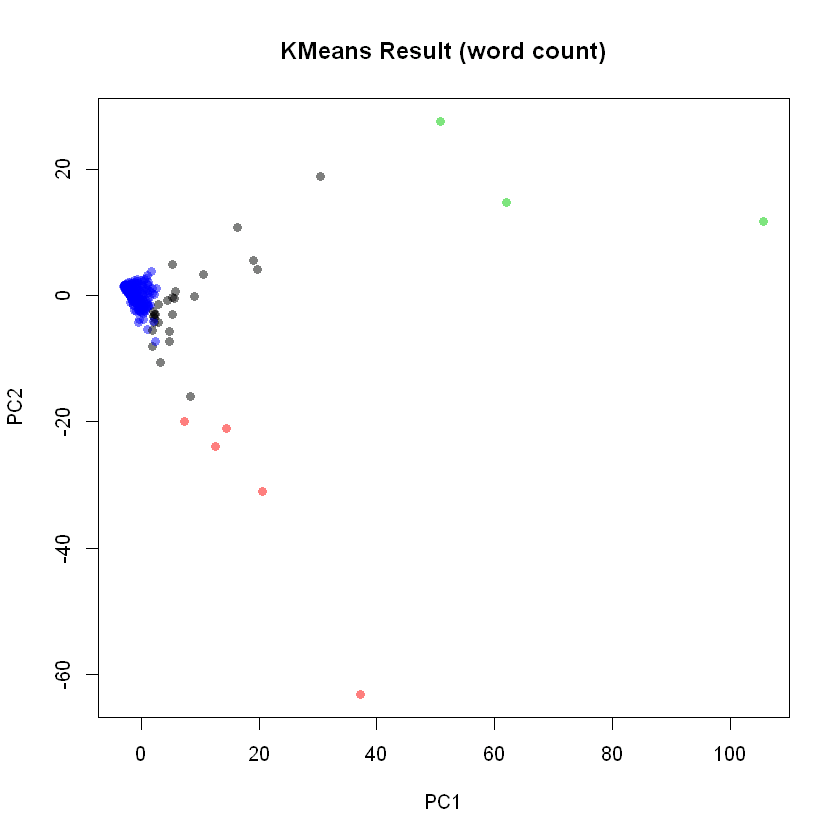

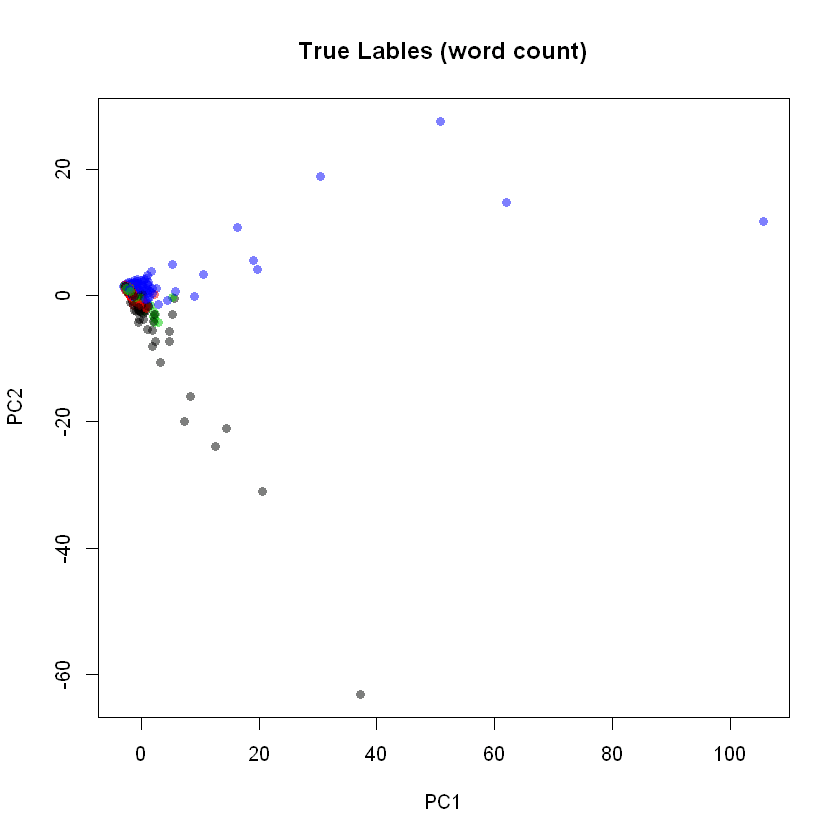

In [5]:
## perform pca
p.comp <- prcomp(m)    

## plot the kmeans outcome
plot(p.comp$x, col=adjustcolor(cl$cl, alpha=0.5), pch=16,  main='KMeans Result (word count)')

## plot the original labels to compare with the previous plot
plot(p.comp$x, col=adjustcolor(as.numeric(factor(labels)), 0.5), pch=16, main='True Lables (word count)')

## A Simple Normalization
As the above figures show, in some cases the data samples are located far from each other, while in some other cases, they are colocated. ALso note that the scale of PCs can be very different. This suggests that with a normalization we might get better result as the performance of Kmeans is very sensitive to the distance between the points.

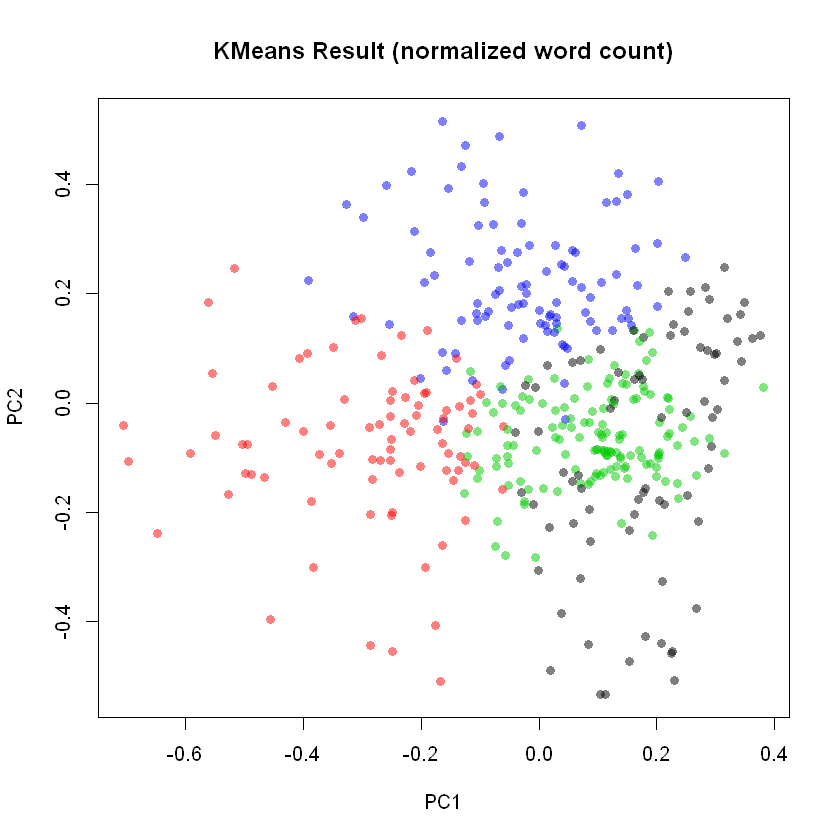

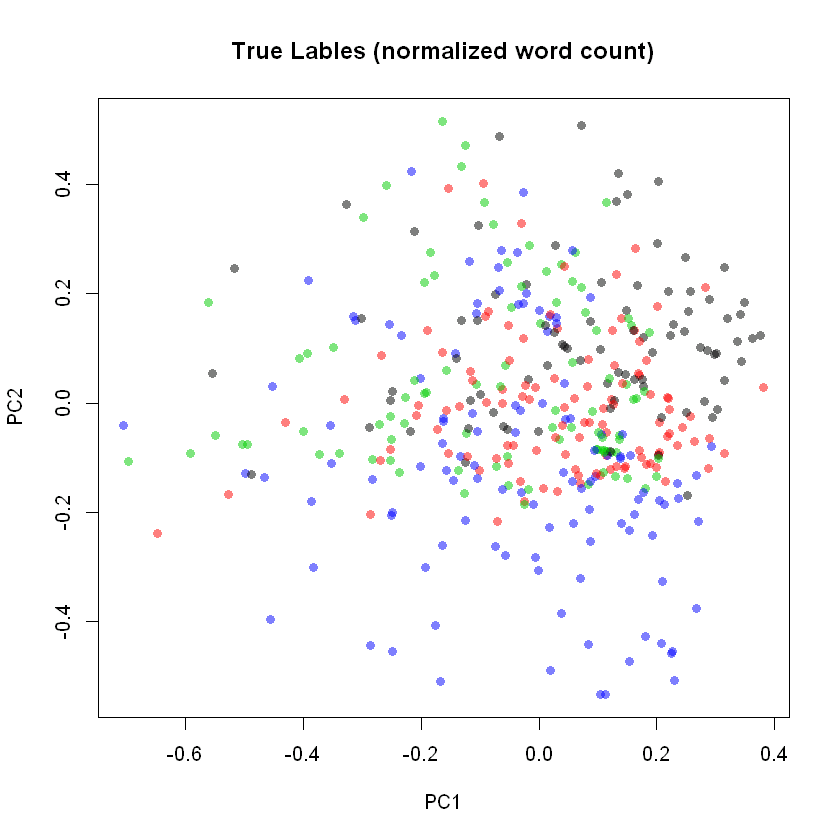

In [6]:
## define an auxiliary function that calculates euclidian normalization
norm.eucl <- function(m) m/apply(m, MARGIN=1, FUN=function(x) sum(x^2)^.5)
m.norm <- norm.eucl(m)
m.norm[is.na(m.norm)]=0

## perform kmeans again
cl <- kmeans(m.norm, 4)

## plot the results and compare with the true labels
p.comp <- prcomp(m.norm)    
plot(p.comp$x, col=adjustcolor(cl$cl, alpha=0.5), pch=16, main='KMeans Result (normalized word count)')
plot(p.comp$x, col=adjustcolor(as.numeric(factor(labels)), 0.5), pch=16, main='True Lables (normalized word count)')

## A More Advanced Set of Features

The simple normalization improved Kmeans outcome, but not that much. This suggests that not only the initialization and number of clusters have great impact on the kmeans outcome, but the feature space itself should be discriminative as well. In the followings, we try another feature (instead of the simple word counts) that is knonw as Term Frequency-Inverse Document Frequency (TFIDF). In its core, TFIDF in nothing but weighted word count.

Let's calculate TFIDF feature values and then repeat the above experimetns.

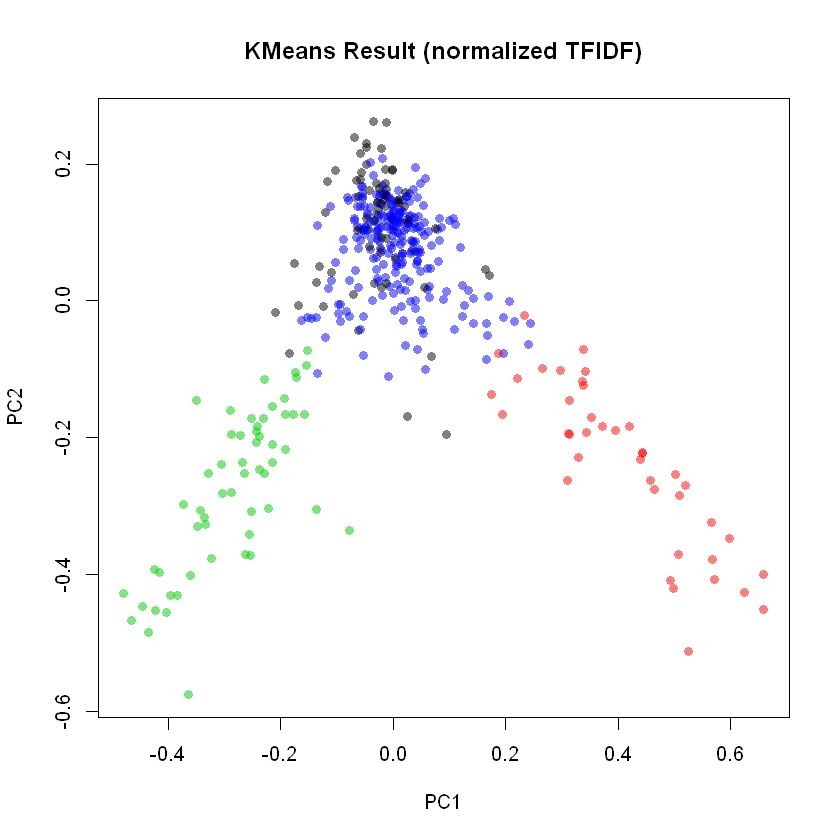

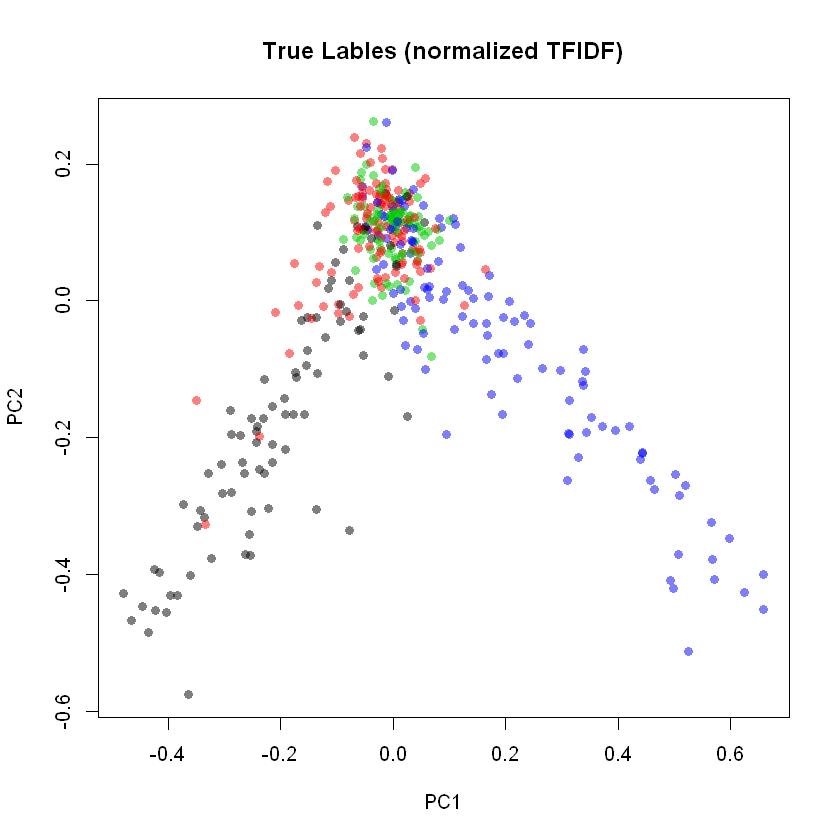

In [7]:
## calculate the tfidf weights
dtm_tfxidf <- weightTfIdf(dtm)

## perform k-means
m <- as.matrix(dtm_tfxidf)
rownames(m) <- 1:nrow(m)
cl <- kmeans(m, 4)

## plot the results
#p.comp <- prcomp(m)
#plot(p.comp$x, col=adjustcolor(cl$cl, alpha=0.5), pch=16, main='KMeans Result (TFIDF)')
#plot(p.comp$x, col=adjustcolor(as.numeric(factor(labels)), 0.5), pch=16, main='True Lables (TFIDF)')

## Let normalize (using euclidian distance) the tfidf weights and repeat the experiments
m.norm <- norm.eucl(m)
m.norm[is.na(m.norm)]=0
cl <- kmeans(m.norm, 4)
p.comp <- prcomp(m.norm)
plot(p.comp$x, col=adjustcolor(cl$cl, alpha=0.5), pch=16, main='KMeans Result (normalized TFIDF)')
plot(p.comp$x, col=adjustcolor(as.numeric(factor(labels)), 0.5), pch=16, main='True Lables (normalized TFIDF)')

## Discussions:
1- We knew that KMeans is very sensitive to its initialzation (initial cluster centers) and number of clusters (`k`). Apart from that, what is the other main limitation of Kmeans algorithm (**Hint:** Think of features set and distance metric)?

2- Given the limitaitons we count in the previous question, what could be the remedy (**Hint:** Think of EM techniques that are covered in the previous chapter)?